# Starting Age Sensitivity Analysis

This notebook runs the glaucoma model analysis **three times** with different starting ages:

1. **Low age scenario**: Starting age = 55 years
2. **Base case scenario**: Starting age = 61 years (median)
3. **High age scenario**: Starting age = 65 years

The analysis compares AI-enhanced vs traditional glaucoma screening across all three starting age scenarios.

---

### 📊 Analysis Setup

All other parameters remain constant across scenarios - only the starting age varies. This allows us to isolate the impact of patient age at screening initiation on cost-effectiveness.

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy

sys.path.append('../src') 

from glaucoma_model.utils import (
    save_scenario_results
)
from glaucoma_model.analysis import (
    comprehensive_cost_effectiveness_analysis,
    create_summary_table
)

from glaucoma_model.parameters import (
    Parameter,
    GlaucomaParameters
)

from glaucoma_model.model import (
    BaseGlaucomaModel,
    AIGlaucomaModel,
    NonAIGlaucomaModel
)

from glaucoma_model.analysis import *

print("✓ Imports complete")

Parameter class defined!
Enhanced GlaucomaParameters class defined with state-specific screening accuracy, mortality odds ratios, and false positive disutility!
Enhanced models with age-dependent mortality from life tables defined!
✓ Imports complete


## Configuration

In [2]:
# Analysis parameters
N_ITERATIONS = 5000
YEARS = 30
MALE_PROPORTION = 0.55
RANDOM_SEED = 42

# Define THREE starting age scenarios
starting_ages = {
    'Low': 55,
    'Base': 61,
    'High': 65
}

print("=== STARTING AGE SCENARIOS ===")
print(f"Scenario 1 (Low): Starting age = {starting_ages['Low']} years")
print(f"Scenario 2 (Base): Starting age = {starting_ages['Base']} years")
print(f"Scenario 3 (High): Starting age = {starting_ages['High']} years")
print(f"\nAll scenarios use {N_ITERATIONS} iterations over {YEARS} years")

=== STARTING AGE SCENARIOS ===
Scenario 1 (Low): Starting age = 55 years
Scenario 2 (Base): Starting age = 61 years
Scenario 3 (High): Starting age = 65 years

All scenarios use 5000 iterations over 30 years


## Define Helper Function

This function runs the complete analysis for a single starting age.

In [3]:
def run_single_scenario(starting_age, scenario_name):
    """
    Run the complete analysis for a single starting age
    
    Parameters:
    -----------
    starting_age : int
        The starting age for the cohort (e.g., 55, 61, 65)
    scenario_name : str
        Name for this scenario
    
    Returns:
    --------
    dict : Results including summary table and comprehensive results
    """
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name}")
    print(f"Starting Age: {starting_age} years")
    print(f"{'='*80}\n")
    
    # Initialize models with specified starting age
    model_ai = AIGlaucomaModel(starting_age=starting_age)
    model_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    model_non_ai = NonAIGlaucomaModel(starting_age=starting_age)
    model_non_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    # Initial distribution (fixed proportions: 38 mild, 9 moderate, 7 severe, 0 VI, 0 dead)
    initial_dist = [38, 9, 7, 0, 0]
    initial_dist = np.array(initial_dist) / np.sum(initial_dist)
    
    # Run AI PSA
    print(f"Running AI Model PSA ({N_ITERATIONS} iterations)...")
    ai_psa_results = model_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Run Non-AI PSA
    print(f"Running Non-AI Model PSA ({N_ITERATIONS} iterations)...")
    non_ai_psa_results = model_non_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Adjust for sensitivity and specificity
    print("Adjusting for sensitivity and specificity...")
    ai_traces = ai_psa_results['trace_tensor']
    non_ai_traces = non_ai_psa_results['trace_tensor']
    variable_names = ai_psa_results['trace_variable_names']
    
    ai_eff0_psa_traces = copy.deepcopy(ai_traces)
    ai_eff0_psa_results = copy.deepcopy(ai_psa_results)
    
    sensitivity_value = model_ai.params.screening_accuracy['sensitivity'].mean
    
    # Adjust costs
    for var_name in ['Total_Cost', 'Total_Cost_Disc']:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    # Adjust QALYs
    qaly_vars = ['Total_QALY', 'Total_QALY_Disc', 'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI']
    for var_name in qaly_vars:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    ai_eff0_psa_results['trace_tensor'] = ai_eff0_psa_traces
    
    # Add screening costs
    idx1 = variable_names.index('Total_Cost')
    idx2 = variable_names.index('Total_Cost_Disc')
    
    prevalence = model_ai.params.screening_params['prevalence_general'].mean
    
    # AI screening costs
    ai_screening_per_case = (1/prevalence) * model_ai.params.costs['ai_screening'].mean
    ai_eff0_psa_results['trace_tensor'][:, 0, idx1] += ai_screening_per_case
    ai_eff0_psa_results['trace_tensor'][:, 0, idx2] += ai_screening_per_case
    
    # False positive costs
    specificity = model_ai.params.screening_accuracy['specificity'].mean
    human_screening_cost = model_ai.params.costs['human_screening'].mean
    false_positives_per_case = ((1 - prevalence) / prevalence) * (1 - specificity)
    
    ai_eff0_psa_results['trace_tensor'][:, 0, idx1] += false_positives_per_case * human_screening_cost
    ai_eff0_psa_results['trace_tensor'][:, 0, idx2] += false_positives_per_case * human_screening_cost
    
    # Run comprehensive analysis
    print("Running comprehensive cost-effectiveness analysis...")
    comprehensive_results = comprehensive_cost_effectiveness_analysis(
        ai_eff0_psa_results, non_ai_psa_results,
        time_horizons=[5, 10, 15, 20, 30],
        thresholds=[0, 20000, 50000, 75000, 100000, 150000, 200000],
        confidence_level=0.95,
        discounted=True
    )
    
    summary_table = create_summary_table(comprehensive_results)
    
    return {
        'scenario_name': scenario_name,
        'starting_age': starting_age,
        'comprehensive_results': comprehensive_results,
        'summary_table': summary_table,
        'ai_psa_results': ai_psa_results,
        'non_ai_psa_results': non_ai_psa_results,
        'ai_eff0_psa_results': ai_eff0_psa_results
    }

print("✓ Helper function defined")

✓ Helper function defined


## Scenario 1: Low Starting Age (55 years)

Running analysis with starting age = 55 years

In [4]:
results_low = run_single_scenario(
    starting_age=starting_ages['Low'],
    scenario_name="Low Starting Age (55)"
)


SCENARIO: Low Starting Age (55)
Starting Age: 55 years

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 55)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/5000
  A

### Summary Table - Low Age Scenario

In [5]:
print("\n=== LOW AGE SCENARIO (55 years) - SUMMARY TABLE ===")
print(results_low['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_low['summary_table'])


=== LOW AGE SCENARIO (55 years) - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €813     [€-1,958, €3,613]                 0.071       [-0.195, 0.331]  €11,432    €2,979      €1,807 [€-147,181, €133,635]       64.8%       76.9%        81.4%
    10 years               €-1,489     [€-8,415, €5,049]                 0.228       [-0.375, 0.821]  €-6,535   €-2,208     €-3,449 [€-121,258, €124,303]       83.6%       87.9%        89.3%
    15 years               €-5,833    [€-18,171, €5,395]                 0.437       [-0.574, 1.425] €-13,335   €-6,253     €-6,935 [€-112,238, €113,895]       92.2%       93.7%        94.2%
    20 years              €-10,980    [€-29,140, €5,225]                 0.676       [-0.794, 2.095] €-16,252  €-11,419     €-9,525 [€-139,479, €107,605]       95.7%       96.4%      

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€813,"[€-1,958, €3,613]",0.071,"[-0.195, 0.331]","€11,432","€2,979","€1,807","[€-147,181, €133,635]",64.8%,76.9%,81.4%
1,10 years,"€-1,489","[€-8,415, €5,049]",0.228,"[-0.375, 0.821]","€-6,535","€-2,208","€-3,449","[€-121,258, €124,303]",83.6%,87.9%,89.3%
2,15 years,"€-5,833","[€-18,171, €5,395]",0.437,"[-0.574, 1.425]","€-13,335","€-6,253","€-6,935","[€-112,238, €113,895]",92.2%,93.7%,94.2%
3,20 years,"€-10,980","[€-29,140, €5,225]",0.676,"[-0.794, 2.095]","€-16,252","€-11,419","€-9,525","[€-139,479, €107,605]",95.7%,96.4%,96.6%
4,30 years,"€-17,793","[€-43,171, €5,242]",1.138,"[-1.047, 3.192]","€-15,635","€-11,283","€-10,660","[€-117,106, €99,916]",97.5%,97.8%,97.8%


### Key Results - Low Age Scenario

In [6]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Age 55) ===")
    results = results_low['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Age 55) ===
ICER: €11,432  ICER (95% CI): €2,979 [-147,181, 133,635]
Incremental Cost: €813
Incremental QALY: 0.071
Probability cost-effective at €20k/QALY: 64.8%
Probability cost-effective at €50k/QALY: 76.9%
Probability cost-effective at €100k/QALY: 81.4%

=== 10-YEAR RESULTS (Age 55) ===
ICER: €-6,535  ICER (95% CI): €-2,208 [-121,258, 124,303]
Incremental Cost: €-1,489
Incremental QALY: 0.228
Probability cost-effective at €20k/QALY: 83.6%
Probability cost-effective at €50k/QALY: 87.9%
Probability cost-effective at €100k/QALY: 89.3%

=== 30-YEAR RESULTS (Age 55) ===
ICER: €-15,635  ICER (95% CI): €-11,283 [-117,106, 99,916]
Incremental Cost: €-17,793
Incremental QALY: 1.138
Probability cost-effective at €20k/QALY: 97.5%
Probability cost-effective at €50k/QALY: 97.8%
Probability cost-effective at €100k/QALY: 97.8%


### Save Low Age Results

In [7]:
results_low['summary_table'].to_csv('../data/starting_age_55_summary.csv', index=False)
print("✓ Low age scenario results saved to ../data/starting_age_55_summary.csv")

✓ Low age scenario results saved to ../data/starting_age_55_summary.csv


## Scenario 2: Base Case Starting Age (61 years)

Running analysis with starting age = 61 years (median)

In [8]:
results_base = run_single_scenario(
    starting_age=starting_ages['Base'],
    scenario_name="Base Case Starting Age (61)"
)


SCENARIO: Base Case Starting Age (61)
Starting Age: 61 years

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/50

### Summary Table - Base Age Scenario

In [9]:
print("\n=== BASE AGE SCENARIO (61 years) - SUMMARY TABLE ===")
print(results_base['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_base['summary_table'])


=== BASE AGE SCENARIO (61 years) - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €817     [€-1,902, €3,569]                 0.070       [-0.192, 0.328]  €11,637    €2,949      €1,766 [€-149,461, €133,426]       64.7%       76.9%        81.3%
    10 years               €-1,315     [€-7,939, €4,944]                 0.222       [-0.358, 0.789]  €-5,916   €-2,122     €-3,124 [€-127,559, €123,218]       83.3%       87.9%        89.3%
    15 years               €-5,026    [€-16,283, €5,305]                 0.423       [-0.532, 1.352] €-11,881   €-6,588     €-6,380 [€-113,390, €106,677]       91.6%       93.4%        94.1%
    20 years               €-8,810    [€-24,369, €5,242]                 0.642       [-0.686, 1.914] €-13,718   €-9,271     €-8,493  [€-117,168, €98,760]       95.0%       95.8%     

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€817,"[€-1,902, €3,569]",0.070,"[-0.192, 0.328]","€11,637","€2,949","€1,766","[€-149,461, €133,426]",64.7%,76.9%,81.3%
1,10 years,"€-1,315","[€-7,939, €4,944]",0.222,"[-0.358, 0.789]","€-5,916","€-2,122","€-3,124","[€-127,559, €123,218]",83.3%,87.9%,89.3%
2,15 years,"€-5,026","[€-16,283, €5,305]",0.423,"[-0.532, 1.352]","€-11,881","€-6,588","€-6,380","[€-113,390, €106,677]",91.6%,93.4%,94.1%
3,20 years,"€-8,810","[€-24,369, €5,242]",0.642,"[-0.686, 1.914]","€-13,718","€-9,271","€-8,493","[€-117,168, €98,760]",95.0%,95.8%,96.0%
4,30 years,"€-11,683","[€-30,396, €5,448]",0.955,"[-0.772, 2.581]","€-12,237","€-10,457","€-8,863","[€-105,881, €81,338]",96.6%,97.1%,97.2%


### Key Results - Base Age Scenario

In [10]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Age 61) ===")
    results = results_base['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Age 61) ===
ICER: €11,637  ICER (95% CI): €2,949 [-149,461, 133,426]
Incremental Cost: €817
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 64.7%
Probability cost-effective at €50k/QALY: 76.9%
Probability cost-effective at €100k/QALY: 81.3%

=== 10-YEAR RESULTS (Age 61) ===
ICER: €-5,916  ICER (95% CI): €-2,122 [-127,559, 123,218]
Incremental Cost: €-1,315
Incremental QALY: 0.222
Probability cost-effective at €20k/QALY: 83.3%
Probability cost-effective at €50k/QALY: 87.9%
Probability cost-effective at €100k/QALY: 89.3%

=== 30-YEAR RESULTS (Age 61) ===
ICER: €-12,237  ICER (95% CI): €-10,457 [-105,881, 81,338]
Incremental Cost: €-11,683
Incremental QALY: 0.955
Probability cost-effective at €20k/QALY: 96.6%
Probability cost-effective at €50k/QALY: 97.1%
Probability cost-effective at €100k/QALY: 97.2%


### Save Base Age Results

In [11]:
results_base['summary_table'].to_csv('../data/starting_age_61_summary.csv', index=False)
print("✓ Base age scenario results saved to ../data/starting_age_61_summary.csv")

✓ Base age scenario results saved to ../data/starting_age_61_summary.csv


## Scenario 3: High Starting Age (65 years)

Running analysis with starting age = 65 years

In [12]:
results_high = run_single_scenario(
    starting_age=starting_ages['High'],
    scenario_name="High Starting Age (65)"
)


SCENARIO: High Starting Age (65)
Starting Age: 65 years

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 65)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/5000
  

### Summary Table - High Age Scenario

In [13]:
print("\n=== HIGH AGE SCENARIO (65 years) - SUMMARY TABLE ===")
print(results_high['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_high['summary_table'])


=== HIGH AGE SCENARIO (65 years) - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €825     [€-1,848, €3,533]                 0.070       [-0.189, 0.325]  €11,842    €3,055      €1,734 [€-147,141, €138,218]       64.5%       76.8%        81.2%
    10 years               €-1,157     [€-7,506, €4,851]                 0.218       [-0.344, 0.770]  €-5,321   €-2,336     €-2,840 [€-128,576, €117,828]       82.9%       87.7%        89.2%
    15 years               €-4,267    [€-14,607, €5,254]                 0.407       [-0.495, 1.276] €-10,483   €-5,542     €-5,915  [€-108,102, €98,608]       91.1%       93.1%        93.7%
    20 years               €-6,811    [€-19,999, €5,273]                 0.599       [-0.594, 1.738] €-11,373   €-8,723     €-7,414  [€-108,444, €83,590]       94.2%       95.3%     

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€825,"[€-1,848, €3,533]",0.070,"[-0.189, 0.325]","€11,842","€3,055","€1,734","[€-147,141, €138,218]",64.5%,76.8%,81.2%
1,10 years,"€-1,157","[€-7,506, €4,851]",0.218,"[-0.344, 0.770]","€-5,321","€-2,336","€-2,840","[€-128,576, €117,828]",82.9%,87.7%,89.2%
2,15 years,"€-4,267","[€-14,607, €5,254]",0.407,"[-0.495, 1.276]","€-10,483","€-5,542","€-5,915","[€-108,102, €98,608]",91.1%,93.1%,93.7%
3,20 years,"€-6,811","[€-19,999, €5,273]",0.599,"[-0.594, 1.738]","€-11,373","€-8,723","€-7,414","[€-108,444, €83,590]",94.2%,95.3%,95.5%
4,30 years,"€-7,985","[€-22,679, €5,459]",0.776,"[-0.615, 2.103]","€-10,284","€-8,782","€-7,456","[€-102,353, €82,792]",95.3%,96.0%,96.2%


### Key Results - High Age Scenario

In [14]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Age 65) ===")
    results = results_high['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Age 65) ===
ICER: €11,842  ICER (95% CI): €3,055 [-147,141, 138,218]
Incremental Cost: €825
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 64.5%
Probability cost-effective at €50k/QALY: 76.8%
Probability cost-effective at €100k/QALY: 81.2%

=== 10-YEAR RESULTS (Age 65) ===
ICER: €-5,321  ICER (95% CI): €-2,336 [-128,576, 117,828]
Incremental Cost: €-1,157
Incremental QALY: 0.218
Probability cost-effective at €20k/QALY: 82.9%
Probability cost-effective at €50k/QALY: 87.7%
Probability cost-effective at €100k/QALY: 89.2%

=== 30-YEAR RESULTS (Age 65) ===
ICER: €-10,284  ICER (95% CI): €-8,782 [-102,353, 82,792]
Incremental Cost: €-7,985
Incremental QALY: 0.776
Probability cost-effective at €20k/QALY: 95.3%
Probability cost-effective at €50k/QALY: 96.0%
Probability cost-effective at €100k/QALY: 96.2%


### Save High Age Results

In [15]:
results_high['summary_table'].to_csv('../data/starting_age_65_summary.csv', index=False)
print("✓ High age scenario results saved to ../data/starting_age_65_summary.csv")

✓ High age scenario results saved to ../data/starting_age_65_summary.csv


## Comparison of Scenarios

Direct comparison of all three starting age scenarios

In [16]:
print("\n" + "="*80)
print("COMPARISON OF SCENARIOS")
print("="*80)

print(f"\nScenario 1 (Low): Starting Age = {results_low['starting_age']} years")
print(f"Scenario 2 (Base): Starting Age = {results_base['starting_age']} years")
print(f"Scenario 3 (High): Starting Age = {results_high['starting_age']} years")
print(f"\nAge range: {starting_ages['High'] - starting_ages['Low']} years")


COMPARISON OF SCENARIOS

Scenario 1 (Low): Starting Age = 55 years
Scenario 2 (Base): Starting Age = 61 years
Scenario 3 (High): Starting Age = 65 years

Age range: 10 years


### 10-Year ICER Comparison

In [17]:
print("\n=== 10-YEAR ICER COMPARISON ===")
print("-" * 80)

res_low = results_low['comprehensive_results']['10_years']['summary']
res_base = results_base['comprehensive_results']['10_years']['summary']
res_high = results_high['comprehensive_results']['10_years']['summary']

print(f"\nAge 55 Scenario:")
print(f"  ICER: €{res_low['incremental_cost_mean']/res_low['incremental_qaly_mean']:,.0f}  ICER mean: €{res_low['icer_mean']:,.0f}")
print(f"  Incremental Cost: €{res_low['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_low['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_low['prob_cost_effective_50k']:.1f}%")

print(f"\nAge 61 Scenario (Base):")
print(f"  ICER: €{res_base['incremental_cost_mean']/res_base['incremental_qaly_mean']:,.0f}  ICER mean: €{res_base['icer_mean']:,.0f}")
print(f"  Incremental Cost: €{res_base['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_base['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_base['prob_cost_effective_50k']:.1f}%")

print(f"\nAge 65 Scenario:")
print(f"  ICER: €{res_high['incremental_cost_mean']/res_high['incremental_qaly_mean']:,.0f}  ICER mean: €{res_high['icer_mean']:,.0f}")
print(f"  Incremental Cost: €{res_high['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_high['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_high['prob_cost_effective_50k']:.1f}%")

print(f"\nDifferences (Age 55 vs Age 65):")
print(f"  ΔICER: €{res_high['icer_mean'] - res_low['icer_mean']:,.0f}")
print(f"  ΔIncremental Cost: €{res_high['incremental_cost_mean'] - res_low['incremental_cost_mean']:,.0f}")
print(f"  ΔIncremental QALY: {res_high['incremental_qaly_mean'] - res_low['incremental_qaly_mean']:.3f}")
print(f"  ΔProb CE at €50k: {res_high['prob_cost_effective_50k'] - res_low['prob_cost_effective_50k']:.1f} percentage points")


=== 10-YEAR ICER COMPARISON ===
--------------------------------------------------------------------------------

Age 55 Scenario:
  ICER: €-6,535  ICER mean: €-2,208
  Incremental Cost: €-1,489
  Incremental QALY: 0.228
  Prob CE at €50k: 87.9%

Age 61 Scenario (Base):
  ICER: €-5,916  ICER mean: €-2,122
  Incremental Cost: €-1,315
  Incremental QALY: 0.222
  Prob CE at €50k: 87.9%

Age 65 Scenario:
  ICER: €-5,321  ICER mean: €-2,336
  Incremental Cost: €-1,157
  Incremental QALY: 0.218
  Prob CE at €50k: 87.7%

Differences (Age 55 vs Age 65):
  ΔICER: €-128
  ΔIncremental Cost: €331
  ΔIncremental QALY: -0.010
  ΔProb CE at €50k: -0.2 percentage points


### Comparison Table

In [19]:
# Create comparison dataframe
comparison_data = []

for time_horizon in [5, 10, 15, 20, 30]:
    res_low = results_low['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_base = results_base['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_high = results_high['comprehensive_results'][f'{time_horizon}_years']['summary']
    
    comparison_data.append({
        'Time_Horizon': f'{time_horizon} years',
        'ICER_Age55': res_low['incremental_cost_mean']/res_low['incremental_qaly_mean'],
        'ICER_Age61': res_base['incremental_cost_mean']/res_base['incremental_qaly_mean'],
        'ICER_Age65': res_high['incremental_cost_mean']/res_high['incremental_qaly_mean'],
        'ICER_Age55_mean': res_low['icer_mean'],
        'ICER_Age61_mean': res_base['icer_mean'],
        'ICER_Age65_mean': res_high['icer_mean'],
        'IncCost_Age55': res_low['incremental_cost_mean'],
        'IncCost_Age61': res_base['incremental_cost_mean'],
        'IncCost_Age65': res_high['incremental_cost_mean'],
        'IncQALY_Age55': res_low['incremental_qaly_mean'],
        'IncQALY_Age61': res_base['incremental_qaly_mean'],
        'IncQALY_Age65': res_high['incremental_qaly_mean'],
        'ProbCE50k_Age55': res_low['prob_cost_effective_50k'],
        'ProbCE50k_Age61': res_base['prob_cost_effective_50k'],
        'ProbCE50k_Age65': res_high['prob_cost_effective_50k']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===")
display(comparison_df)

# Save comparison table
comparison_df.to_csv('../data/starting_age_comparison.csv', index=False)
print("\n✓ Comparison table saved to ../data/starting_age_comparison.csv")


=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===


,Time_Horizon,ICER_Age55,ICER_Age61,ICER_Age65,ICER_Age55_mean,ICER_Age61_mean,ICER_Age65_mean,IncCost_Age55,IncCost_Age61,IncCost_Age65,IncQALY_Age55,IncQALY_Age61,IncQALY_Age65,ProbCE50k_Age55,ProbCE50k_Age61,ProbCE50k_Age65
0,5 years,11431.858030,11636.683314,11841.677927,2979.476193,2948.638954,3054.543533,812.707123,817.326387,824.748826,0.071091,0.070237,0.069648,76.926221,76.871303,76.846185
1,10 years,-6535.096718,-5916.429194,-5320.510134,-2207.835038,-2121.736128,-2336.133852,-1488.767841,-1315.028110,-1157.338643,0.227811,0.222267,0.217524,87.886808,87.900934,87.710404
2,15 years,-13335.083289,-11881.484594,-10483.234664,-6253.186009,-6588.016722,-5542.070631,-5832.997651,-5025.634944,-4267.218015,0.437417,0.422980,0.407052,93.691494,93.407935,93.058656
3,20 years,-16252.351621,-13718.053373,-11372.599821,-11418.515718,-9270.929037,-8723.254940,-10980.337144,-8809.632640,-6810.813381,0.675615,0.642193,0.598879,96.423491,95.813008,95.288383
4,30 years,-15634.801375,-12236.581079,-10283.998574,-11283.273385,-10457.237151,-8781.690872,-17793.041337,-11682.978059,-7984.758395,1.138041,0.954758,0.776425,97.751671,97.104677,96.019398



✓ Comparison table saved to ../data/starting_age_comparison.csv


## Visualizations

### ICER Comparison Across Time Horizons

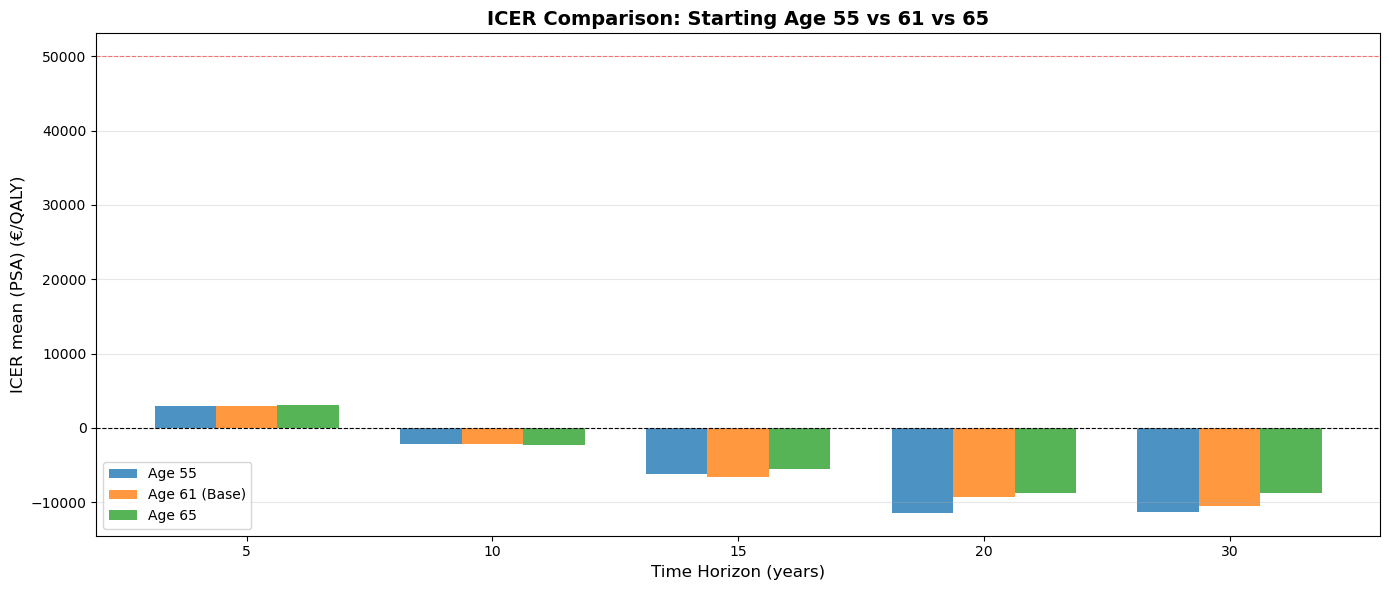

✓ ICER comparison plot saved to ../data/starting_age_icer_comparison.png


In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

time_horizons = [5, 10, 15, 20, 30]
icers_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_base = [results_base['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_high = [results_high['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]

x = np.arange(len(time_horizons))
width = 0.25

bars1 = ax.bar(x - width, icers_low, width, label='Age 55', alpha=0.8)
bars2 = ax.bar(x, icers_base, width, label='Age 61 (Base)', alpha=0.8)
bars3 = ax.bar(x + width, icers_high, width, label='Age 65', alpha=0.8)

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('ICER mean (PSA) (€/QALY)', fontsize=12)
ax.set_title('ICER Comparison: Starting Age 55 vs 61 vs 65', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(time_horizons)
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.axhline(y=50000, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='€50k threshold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/starting_age_icer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ICER comparison plot saved to ../data/starting_age_icer_comparison.png")

### Probability of Cost-Effectiveness Comparison

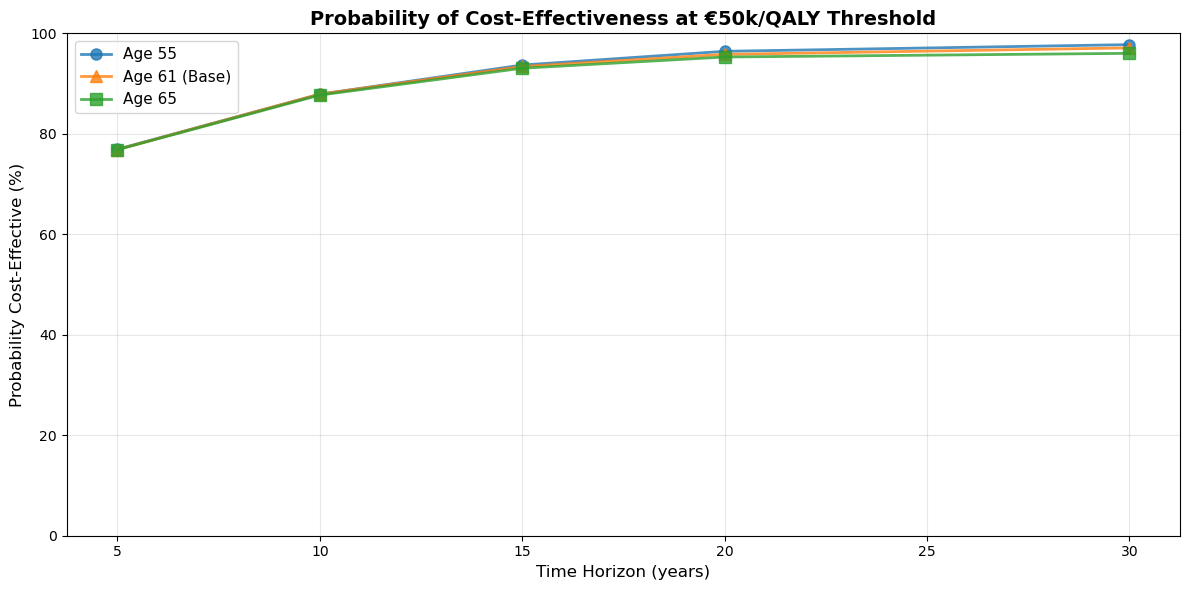

✓ Probability CE comparison plot saved to ../data/starting_age_prob_ce_comparison.png


In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

prob_ce_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_base = [results_base['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_high = [results_high['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]

ax.plot(time_horizons, prob_ce_low, marker='o', linewidth=2, markersize=8, label='Age 55', alpha=0.8)
ax.plot(time_horizons, prob_ce_base, marker='^', linewidth=2, markersize=8, label='Age 61 (Base)', alpha=0.8)
ax.plot(time_horizons, prob_ce_high, marker='s', linewidth=2, markersize=8, label='Age 65', alpha=0.8)

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('Probability Cost-Effective (%)', fontsize=12)
ax.set_title('Probability of Cost-Effectiveness at €50k/QALY Threshold', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../data/starting_age_prob_ce_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Probability CE comparison plot saved to ../data/starting_age_prob_ce_comparison.png")

### Incremental QALYs by Starting Age

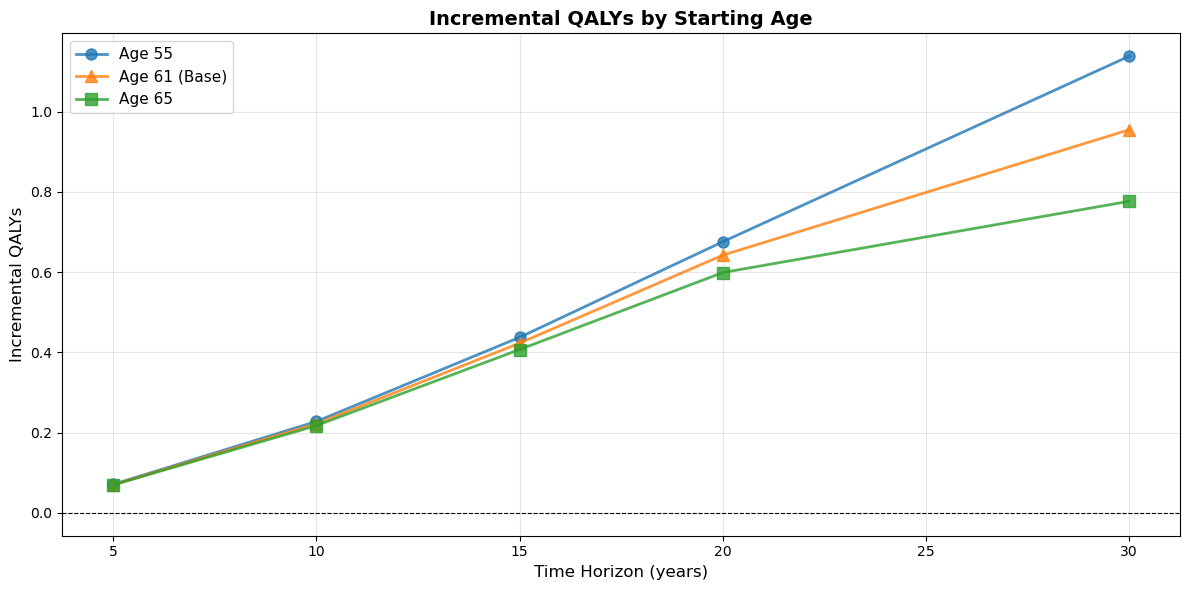

✓ QALYs comparison plot saved to ../data/starting_age_qalys_comparison.png


In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

qalys_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['incremental_qaly_mean'] for t in time_horizons]
qalys_base = [results_base['comprehensive_results'][f'{t}_years']['summary']['incremental_qaly_mean'] for t in time_horizons]
qalys_high = [results_high['comprehensive_results'][f'{t}_years']['summary']['incremental_qaly_mean'] for t in time_horizons]

ax.plot(time_horizons, qalys_low, marker='o', linewidth=2, markersize=8, label='Age 55', alpha=0.8)
ax.plot(time_horizons, qalys_base, marker='^', linewidth=2, markersize=8, label='Age 61 (Base)', alpha=0.8)
ax.plot(time_horizons, qalys_high, marker='s', linewidth=2, markersize=8, label='Age 65', alpha=0.8)

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('Incremental QALYs', fontsize=12)
ax.set_title('Incremental QALYs by Starting Age', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig('../data/starting_age_qalys_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ QALYs comparison plot saved to ../data/starting_age_qalys_comparison.png")

## Summary and Conclusions

In [24]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print("\n📊 Files saved:")
print("  - ../data/starting_age_55_summary.csv")
print("  - ../data/starting_age_61_summary.csv")
print("  - ../data/starting_age_65_summary.csv")
print("  - ../data/starting_age_comparison.csv")
print("  - ../data/starting_age_icer_comparison.png")
print("  - ../data/starting_age_prob_ce_comparison.png")
print("  - ../data/starting_age_qalys_comparison.png")

print("\n📈 Key Findings (10-year horizon):")
print(f"  Age 55: ICER = €{res_low['icer_mean']:,.0f}/QALY, Incremental QALYs = {res_low['incremental_qalys_mean']:.3f}")
print(f"  Age 61: ICER = €{res_base['icer_mean']:,.0f}/QALY, Incremental QALYs = {res_base['incremental_qalys_mean']:.3f}")
print(f"  Age 65: ICER = €{res_high['icer_mean']:,.0f}/QALY, Incremental QALYs = {res_high['incremental_qalys_mean']:.3f}")

print("\n💡 Interpretation:")
if res_low['icer_mean'] < res_high['icer_mean']:
    print("  Screening at younger ages appears more cost-effective.")
else:
    print("  Screening at older ages appears more cost-effective.")

if res_low['incremental_qalys_mean'] > res_high['incremental_qalys_mean']:
    print("  Younger patients accumulate more incremental QALYs (longer time horizon).")
else:
    print("  Older patients accumulate more incremental QALYs.")

print("\n✓ All three scenarios have been successfully analyzed and compared.")


ANALYSIS COMPLETE

📊 Files saved:
  - ../data/starting_age_55_summary.csv
  - ../data/starting_age_61_summary.csv
  - ../data/starting_age_65_summary.csv
  - ../data/starting_age_comparison.csv
  - ../data/starting_age_icer_comparison.png
  - ../data/starting_age_prob_ce_comparison.png
  - ../data/starting_age_qalys_comparison.png

📈 Key Findings (10-year horizon):


KeyError: 'incremental_qalys_mean'